<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/model-classification/Classify_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
from google.colab import files
uploaded = files.upload()

Saving data_price_patterns.zip to data_price_patterns (1).zip


## Import packages

In [21]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
import os
import zipfile
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam, SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from scipy import stats

## Get data at pattern for training & testing

In [22]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
# for filename in uploaded.keys():
#     print(filename)
#     if 'double_top_data_patterns.csv' not in filename:
#     # if 'data_patterns.csv' not in filename:
#         print('Skipping file', filename)
#         continue
#     try:
#         df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
#                         header=None)
#         price_patterns_df = price_patterns_df.append(df)
#     except:
#         print('Error', filename)

filebytes = io.BytesIO(uploaded['data_price_patterns.zip'])
myzipfile = zipfile.ZipFile(filebytes)
# for filename in os.listdir('.'):
#     if not os.path.isfile(filename):
#         continue
multi_features_data = []
columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
for filename in myzipfile.namelist():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    # try:
    file = myzipfile.open(filename)
    fileread = file.read()
    # print(io.BytesIO(fileread))
    df = pd.read_csv(io.BytesIO(fileread))
    # print(df.head())
    # multi_features_data.append(df.to_numpy())
    multi_features_data.append(df[columns].to_numpy())
    # Plot the time series
    # df.plot(subplots=True,
    #         layout=(6, 3),
    #         figsize=(22,22),
    #         fontsize=10, 
    #         linewidth=2,
    #         sharex=False,
    #         title='Visualization of the original Time Series')
    # plt.show()
    # price_patterns_df = price_patterns_df.append(df)
    y_data = df['Close']
    prices = np.array(y_data).reshape(-1, 1)
    price_patterns_df = price_patterns_df.append(pd.DataFrame(prices).T)
    # except:
    #     print('Error', filename)

multi_features_data = np.array(multi_features_data)
print(multi_features_data)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

Streaming output truncated to the last 5000 lines.
ADDDF_2000-01-01 00:00:00_2021-06-11_30_001_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_002_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_003_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_004_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_005_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_006_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_007_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_008_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_009_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_010_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_011_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_012_double_top_data_patterns.csv
ADDDF_2000-01-01 00:00:00_2021-06-11_30_013_double_top_data_patterns.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,79.199997,78.959999,77.400002,78.839996,78.120003,75.959999,76.199997,74.040001,75.000000,75.120003,75.120003,74.400002,75.959999,75.720001,76.320000,76.199997,75.720001,76.320000,76.559998,77.760002,76.440002,77.160004,76.800003,77.400002,77.519997,77.279999,79.320000,77.400002,78.480003,77.279999,76.800003
1,724.020020,758.340027,737.219971,728.640015,742.500000,742.500000,743.820007,758.340027,733.260010,696.299988,686.400024,708.179993,706.200012,739.200012,717.419983,692.340027,693.000000,693.659973,694.979980,726.000000,720.719971,720.059998,716.760010,719.400024,757.679993,744.479980,743.820007,732.599976,737.880005,709.500000,679.799988
2,182160.000000,173844.000000,166716.000000,168300.000000,173052.000000,177408.000000,180576.000000,174240.000000,187308.000000,193644.000000,189288.000000,188496.000000,203544.000000,201960.000000,198792.000000,191664.000000,195624.000000,200376.000000,203940.000000,198792.000000,196812.000000,194832.000000,199188.000000,203148.000000,217800.000000,236412.000000,245124.000000,237204.000000,237996.000000,229680.000000,216612.000000
3,225.000000,240.000000,232.500000,232.500000,240.000000,240.000000,240.000000,225.000000,210.000000,232.500000,240.000000,240.000000,232.500000,240.000000,240.000000,232.500000,225.000000,225.000000,225.000000,232.500000,232.500000,225.000000,217.500000,225.000000,217.500000,232.500000,240.000000,232.500000,240.000000,225.000000,225.000000
4,108.940002,108.910004,107.290001,107.599998,105.300003,106.360001,106.720001,109.080002,103.260002,101.930000,102.989998,103.760002,104.419998,104.230003,104.080002,105.320000,105.860001,104.500000,101.830002,102.360001,102.160004,99.160004,98.199997,99.230003,101.010002,99.260002,101.879997,99.269997,101.379997,99.059998,98.290001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,148896.000000,149292.000000,158400.000000,164340.000000,158400.000000,166320.000000,162360.000000,154440.000000,188100.000000,225720.000000,234036.000000,267300.000000,245520.000000,241560.000000,258984.000000,243144.000000,267696.000000,256212.000000,283140.000000,294228.000000,294624.000000,295812.000000,294228.000000,280764.000000,275220.000000,284328.000000,281160.000000,286308.000000,276408.000000,274428.000000,279180.000000
7174,17.620001,17.139999,17.510000,17.520000,17.490000,18.020000,17.500000,17.200001,17.219999,17.000000,17.120001,16.090000,16.110001,16.940001,16.889999,16.379999,16.150000,16.440001,16.250000,15.960000,15.520000,16.110001,16.500000,16.379999,17.510000,17.100000,16.840000,17.719999,16.990000,16.790001,16.209999
7175,409.996002,402.839996,404.667999,430.634003,447.750000,442.679993,498.320007,475.049988,447.369995,407.000000,418.320007,330.209991,366.279999,371.339996,372.720001,419.619995,449.760010,441.760010,423.429993,442.149994,449.390015,424.230011,380.359985,387.790009,407.339996,421.200012,419.070007,429.010010,448.160004,415.089996,425.679993
7176,92.099998,89.650002,90.949997,89.949997,87.650002,92.599998,93.949997,96.000000,95.300003,91.800003,86.000000,85.750000,81.349998,83.800003,89.650002,92.500000,91.800003,87.900002,87.650002,92.599998,90.849998,87.300003,91.449997,92.099998,91.000000,92.900002,91.400002,93.150002,91.699997,89.349998,87.800003


In [24]:
n_samples, steps, n_features = multi_features_data.shape
multi_features_data_df = pd.DataFrame(
    multi_features_data.reshape(n_samples * steps, n_features),
    index=pd.MultiIndex.from_product([range(n_samples), range(steps)]),
    columns=columns
)
# panel = pd.Panel(multi_features_data)
# panel.to_frame()
multi_features_data_df.head(31)

High        Low       Open      Close     Volume  Adj Close
0 0   96.600601  93.236397  96.120003  93.717003  2047774.0  69.595909
  1   94.918503  92.996101  93.717003  93.813118  2075988.0  69.667267
  2   91.362061  86.892479  91.362061  88.093979  4309363.0  65.420120
  3   92.515503  88.190102  88.190102  90.400864  3056513.0  67.133270
  4   91.602364  87.084717  90.400864  88.045921  1528173.0  65.384460
  5   89.199364  85.931282  88.045921  86.748299  2096962.0  64.420815
  6   87.084717  84.729782  86.748299  85.450684  2615730.0  63.457218
  7   86.652184  84.201118  85.450684  84.489479  1883146.0  62.743370
  8   86.604118  83.047684  84.489479  83.287979  2532834.0  61.851120
  9   84.777840  83.095741  83.287979  83.432159  1488972.0  61.958202
  10  87.132782  84.345299  84.345299  86.604118  1855764.0  64.313721
  11  90.545036  85.739037  86.604118  89.343536  2324178.0  66.579010
  12  89.343536  85.594856  89.343536  86.700241  1200583.0  64.609230
  13  86.892479  83.480217  86.700241  84.489479  1227382.0  62.961754
  14  84.729782  81.798119  84.489479  81.798119  2058677.0  60.956146
  15  82.951561  78.770340  81.798119  78.818398  2836538.0  58.735661
  16  79.875717  77.232422  78.818398  77.376602  4351644.0  57.661243
  17  80.933037  77.424660  77.424660  78.481979  2251852.0  58.484955
  18  82.278717  79.539299  79.539299  81.029160  2043612.0  60.383118
  19  86.892479  81.846184  81.846184  86.700241  1718269.0  64.609230
  20  89.055183  85.931282  86.700241  88.382339  2156055.0  65.862709
  21  90.448921  87.853683  88.382339  88.286217  2914274.0  65.791061
  22  92.851921  88.911003  88.911003  92.034897  2335747.0  68.584641
  23  92.515503  90.208618  92.034897  90.208618  4203496.0  67.223640
  24  89.439659  86.508003  89.439659  86.892479  1770953.0  64.752464
  25  87.805618  85.402618  86.892479  85.402618  1358052.0  63.642235
  26  86.892479  83.336037  85.402618  83.432159  1669746.0  62.173847
  27  84.729782  82.951561  83.432159  84.249184  1136080.0  62.782639
  28  89.199364  83.047684  84.249184  85.354561  1722347.0  63.606426
  29  85.306503  81.029160  85.306503  82.086479  1953891.0  61.171047
  30  84.729782  79.395119  82.086479  83.480217  1989430.0  62.209648

In [ ]:
#@title Separate into input and output columns: Get data: X and y
pre_time_steps = 30 #@param {type:"integer"}

X_df = price_patterns_df[price_patterns_df.columns[-(pre_time_steps + 1):-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

                0             1   ...            28            29
0        45.680000     46.209999  ...     49.580002     48.880001
1        84.930000     87.080002  ...     93.639999     91.949997
2     27896.000000  26950.000000  ...  32318.000000  31680.000000
3       115.625000    117.625000  ...    125.000000    122.500000
4        58.279999     57.980000  ...     57.250000     55.910000
...            ...           ...  ...           ...           ...
7173     21.750000     21.500000  ...     15.000000     14.610000
7174    187.500000    187.500000  ...    262.500000    247.500000
7175     67.760002     65.779999  ...     64.570000     59.730000
7176   8557.953125   8458.454102  ...   8109.210449   8004.736328
7177     53.849998     59.099998  ...     79.949997     76.349998

[7178 rows x 30 columns]
                30
0        47.830002
1        91.400002
2     30646.000000
3       122.500000
4        55.330002
...            ...
7173     14.110000
7174    270.000000
7175     61

## Find patterns func

In [ ]:
#@title Find pattern params
#@markdown ### Delta price angle degree from data point to trend line
trend_delta =  15#@param {type:"number"}
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta = 0.15 #@param {type:"number"}
#@markdown ### Min height of pattern
min_height = 0.5 #@param {type:"number"}

In [ ]:
#@title Check if data is nearly formed a line

# Get angle of vector ba & vector bc
def get_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    if np.array_equal(a, b) or np.array_equal(a, c) or np.array_equal(b, c):
        return 0

    ba = a - b
    bc = c - b

    if np.all(ba == 0) or np.all(bc == 0):
        return 0

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    # print(a, b, c)
    # print(cosine_angle)
    angle = np.arccos(cosine_angle)

    deg = np.degrees(angle)
    # print('get_angle({}, {}, {}) = {}'.format(a, b, c, deg))
    return deg

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        angle1 = get_angle([x_data[0], y_data[0]], [x_data[-1], y_data[-1]], [x_data[i], y_data[i]])
        angle2 = get_angle([x_data[-1], y_data[-1]], [x_data[0], y_data[0]], [x_data[i], y_data[i]])
        if (angle1 > trend_delta) or (angle2 > trend_delta):
            b_is_trend = False
            break
        # y_val = a * x_data[i] + b
        # err = abs(y_val - y_data[i])
        # if (err > trend_delta * y_val):
        #     b_is_trend = False
        #     break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [ ]:
#@title Find double top func

def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max
        # print(key_points)

    suspected_double_tops = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            # print(l, r, abs(y_data[l] - y_data[r]))
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                # print(l, k_bottom, r)
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[l: k_bottom + 1], y_data[l: k_bottom + 1]) \
                   and is_trend(x_data[k_bottom: r + 1], y_data[k_bottom: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [ ]:
#@title Find double bottom func

def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart: l + 1]) \
                   and is_trend(x_data[l: k_top + 1], y_data[l: k_top + 1]) \
                   and is_trend(x_data[k_top: r + 1], y_data[k_top: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [ ]:
#@title Visualize result func

def visualize_res(x_data, y_data, suspected_double_tops=[], suspected_double_bottoms=[]):
    # ___ plotting ___
    plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # plot stock data
    plt.plot(x_data, y_data, '-', markersize=1.5, color='magenta', alpha=0.7)
    plt.axis('equal')

    for istart, top1, bottom, top2, iend in suspected_double_tops:
        plt.plot(x_data[istart], y_data[istart], "o", color='r')
        plt.plot(x_data[top1], y_data[top1], "o", color='b')
        plt.plot(x_data[bottom], y_data[bottom], "o", color='g')
        plt.plot(x_data[top2], y_data[top2], "o", color='b')
        plt.plot(x_data[iend], y_data[iend], "o", color='r')
        plt.plot(np.array(x_data)[[istart, top1, bottom, top2, iend]], np.array(y_data)[[istart, top1, bottom, top2, iend]], "-", color='g')

    for istart, bot1, top, bot2, iend in suspected_double_bottoms:
        plt.plot(np.array(x_data)[[istart, bot1, top, bot2, iend]], np.array(y_data)[[istart, bot1, top, bot2, iend]], "-", color='b')

    plt.show()

In [ ]:
# i_debug = 1
# for i, row in enumerate(X_data):
#     # if i < i_debug: continue
#     # if i > i_debug: break
#     # x = np.array(range(len(row)))
#     # y = row.to_numpy()
#     # print(x, y)
#     # print(is_trend(x[8:20], y[8:20]))
#     double_tops = find_double_top(range(len(row)), row)
#     double_bots = find_double_bottom(range(len(row)), row)
#     print(i, double_tops, double_bots)
#     visualize_res(range(len(row)), row, double_tops, double_bots)

## Preprocess & split data

In [ ]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def get_binary_direction(pre, cur, min_change=0):
    d = get_direction(pre, cur, min_change)
    if d < 1:
        d = 0
    return d

def y_preice_to_y_label(X, y, min_change=0, num_classes=2):
    assert len(X) == len(y)
    n = len(y)
    if num_classes <= 2:
        y_label = np.array([get_binary_direction(X[i][-1], y[i], min_change) for i in range(n)])
    else:
        y_label = np.array([get_direction(X[i][-1], y[i], min_change) for i in range(n)])
        # Convert from {-1; 0; 1} to label {0; 1; 2}
        y_label = y_label + 1
    return y_label

In [ ]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax", "StandardScaler"]
min_price_change = 0 #@param {type:"number"}
num_classes = 2 #@param {type:"integer"}

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
y_train_label = y_preice_to_y_label(X_train, y_train, min_price_change, num_classes=num_classes)
if num_classes <= 1:
    y_train_categorical = y_train_label
else:
    y_train_categorical = to_categorical(y_train_label, num_classes=num_classes)
y_test_label = y_preice_to_y_label(X_test, y_test, min_price_change, num_classes=num_classes)
if num_classes <= 1:
    y_test_categorical = y_test_label
else:
    y_test_categorical = to_categorical(y_test_label, num_classes=num_classes)
if scale_method != 'None':
    if scale_method == 'MinMax':
        sc_train = MinMaxScaler(feature_range = (0, 1))
    else:
        sc_train = StandardScaler()
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    y_train_scaled_label = y_preice_to_y_label(X_train_scaled, y_train_scaled, min_price_change, num_classes=num_classes)
    if num_classes <= 1:
        y_train_scaled_categorical = y_train_scaled_label
    else:
        y_train_scaled_categorical = to_categorical(y_train_scaled_label, num_classes=num_classes)
    if scale_method == 'MinMax':
        sc_test = MinMaxScaler(feature_range = (0, 1))
    else:
        sc_test = StandardScaler()
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    y_test_scaled_label = y_preice_to_y_label(X_test_scaled, y_test_scaled, min_price_change, num_classes=num_classes)
    if num_classes <= 1:
        y_test_scaled_categorical = y_test_scaled_label
    else:
        y_test_scaled_categorical = to_categorical(y_test_scaled_label, num_classes=num_classes)
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(y_train_categorical.shape)
print(y_train_scaled_categorical.shape)
print('Stats y_train:', stats.describe(y_train))
print('Stats y_train_scaled:', stats.describe(y_train_scaled))
print('Stats y_train_label:', stats.describe(y_train_label))
print(np.bincount(y_train_label))
print('Stats y_train_categorical:', stats.describe(y_train_categorical))
print('Stats y_train_scaled_label:', stats.describe(y_train_scaled_label))
print(np.bincount(y_train_scaled_label))
print('Stats y_train_scaled_categorical:', stats.describe(y_train_scaled_categorical))
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)
print(y_test_categorical.shape)
print(y_test_scaled_categorical.shape)

# print(X_train)
# print(y_train)
# print(y_train_label)
# print(y_train_categorical)

(5742, 30) (5742, 1)
(5742, 30) (5742, 1)
(5742, 2)
(5742, 2)
Stats y_train: DescribeResult(nobs=5742, minmax=(array([1.]), array([1882440.])), mean=array([13655.48499347]), variance=array([7.46912341e+09]), skewness=array([14.76267175]), kurtosis=array([267.39277109]))
Stats y_train_scaled: DescribeResult(nobs=5742, minmax=(array([-2.07671961]), array([6.2962963])), mean=array([0.42880732]), variance=array([0.12889943]), skewness=array([0.46967085]), kurtosis=array([12.75746499]))
Stats y_train_label: DescribeResult(nobs=5742, minmax=(0, 1), mean=0.5008707767328457, variance=0.25004278803628915, skewness=-0.0034831122135415542, kurtosis=-1.999987867929308)
[2866 2876]
Stats y_train_categorical: DescribeResult(nobs=5742, minmax=(array([0., 0.], dtype=float32), array([1., 1.], dtype=float32)), mean=array([0.49912924, 0.50087076], dtype=float32), variance=array([0.25004208, 0.25004208], dtype=float32), skewness=array([ 0.00348287, -0.00348287], dtype=float32), kurtosis=array([-1.9999546,

In [ ]:
# i_debug = 1
# for i, row in enumerate(X_test):
#     # if i < i_debug: continue
#     # if i > i_debug: break
#     # x = np.array(range(len(row)))
#     # y = row.to_numpy()
#     # print(x, y)
#     # print(is_trend(x[8:20], y[8:20]))
#     double_tops = find_double_top(range(len(row)), row)
#     double_bots = find_double_bottom(range(len(row)), row)
#     print(i, double_tops, double_bots)
#     visualize_res(range(len(row)), row, double_tops, double_bots)

## LSTM model

### Build model

In [ ]:
#@title Build & fit model
lstm_units = 10 #@param {type:"integer"}
dropout_prob = 0.1 #@param {type:"number"}
epochs = 5000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}
lr = 0.001 #@param {type:"number"}



### Train model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
1/1 [==============================] - 21s 21s/step - loss: 0.6958 - accuracy: 0.5030 - val_loss: 0.6937 - val_accuracy: 0.5097
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets
Epoch 2/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.6953 - accuracy: 0.5005 - val_loss: 0.6934 - val_accurac

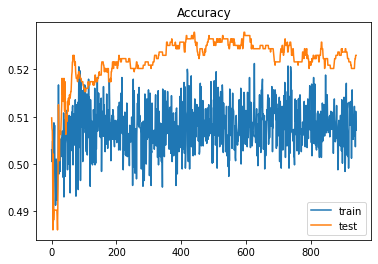

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_classes=2, epochs=6000, batch_size=32768, lr=0.001):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], n_classes))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], n_classes))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                   # return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                #    batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                #    stateful=True,
                   activation='relu'))
    model.add(Dropout(dropout_prob))
    # # Adding a second LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units,
    #             return_sequences=True))
    # model.add(Dropout(dropout_prob))
    # # Adding a third LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units,
    #             return_sequences=True))
    # model.add(Dropout(dropout_prob))
    # # Adding a fourth LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units))
    # model.add(Dropout(dropout_prob))
    # Adding the output layer
    # model.add(Dense(units=1))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(n_classes, activation='softmax'))
    # model.add(Dense(n_classes))
    if n_classes == 1:
        # model.add(Activation('sigmoid'))
        model.add(Dense(n_classes, activation='sigmoid'))
    else:
        # model.add(Activation('softmax'))
        model.add(Dense(n_classes, activation='softmax'))

    # def make_model(input_shape):
    #     input_layer = keras.layers.Input(input_shape)

    #     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    #     conv1 = keras.layers.BatchNormalization()(conv1)
    #     conv1 = keras.layers.ReLU()(conv1)

    #     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    #     conv2 = keras.layers.BatchNormalization()(conv2)
    #     conv2 = keras.layers.ReLU()(conv2)

    #     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    #     conv3 = keras.layers.BatchNormalization()(conv3)
    #     conv3 = keras.layers.ReLU()(conv3)

    #     gap = keras.layers.GlobalAveragePooling1D()(conv3)

    #     output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    #     return keras.models.Model(inputs=input_layer, outputs=output_layer)

    # model = make_model(input_shape=X_train.shape[1:])

    # Adam optimizer
    opt = Adam(learning_rate=lr)
    # opt = SGD(learning_rate=lr, clipvalue=0.5)

    # checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc",
    #                              monitor='val_accuracy', verbose=2,
    #                              save_best_only=True, mode='auto')
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc",
            save_best_only=True,
            monitor="val_accuracy"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=500, verbose=1),
    ]

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if n_classes == 1:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        shuffle=False,
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks)
    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train)
    _, test_acc = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    # for i in range(epochs):
    #     model.fit(X_train, y_train,
    #               validation_data=(X_test, y_test),
    #               shuffle=False,
    #               epochs=1, batch_size=batch_size,
    #               callbacks=callbacks)
    #     model.reset_states()

    return model

# model = train_lstm(X_train, y_train_categorical,
#                    X_test, y_test_categorical,
#                    lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=num_classes,
#                    epochs=epochs, batch_size=batch_size, lr=lr)
model = train_lstm(X_train_scaled, y_train_scaled_categorical,
                   X_test_scaled, y_test_scaled_categorical,
                   lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=num_classes,
                   epochs=epochs, batch_size=batch_size, lr=lr)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [ ]:
def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [ ]:
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc")

In [ ]:
# y_pred = lstm_model.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
y_pred = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))

In [ ]:
y_test_scaled_categorical, y_pred

(array([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32), array([[0.49081337, 0.5091866 ],
        [0.49244902, 0.507551  ],
        [0.4881945 , 0.51180553],
        ...,
        [0.5070454 , 0.4929546 ],
        [0.5076393 , 0.49236074],
        [0.490916  , 0.5090839 ]], dtype=float32))

confusion_matrix: [[339 393]
 [285 419]]
acc: 0.5278551532033426
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       732
           1       0.52      0.60      0.55       704

    accuracy                           0.53      1436
   macro avg       0.53      0.53      0.53      1436
weighted avg       0.53      0.53      0.53      1436

confusion_matrix: [[1269 1597]
 [1191 1685]]
acc: 0.5144548937652386
              precision    recall  f1-score   support

           0       0.52      0.44      0.48      2866
           1       0.51      0.59      0.55      2876

    accuracy                           0.51      5742
   macro avg       0.51      0.51      0.51      5742
weighted avg       0.51      0.51      0.51      5742



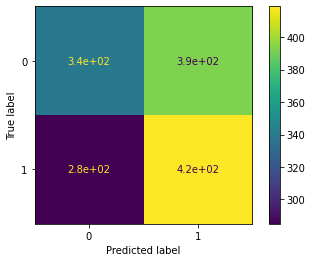

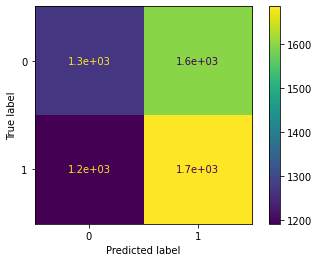

In [ ]:
def show_val_res_label(y_true_label, y_pred_label):
    # y_true_label = y_true_label - 1
    # y_pred_label = y_pred_label - 1
    labels = list(range(np.min(y_true_label), np.max(y_true_label) + 1))
    cm = confusion_matrix(y_true_label, y_pred_label, labels=labels)
    print('confusion_matrix:', cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()

    acc = accuracy_score(y_true_label, y_pred_label)
    print('acc:', acc)

    print(classification_report(y_true_label, y_pred_label))

def show_val_res_categorical(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    show_val_res_label(y_true_label, y_pred_label)

# show_val_res_categorical(y_test_categorical, y_pred)
# show_val_res_categorical(y_train_categorical, lstm_model.predict(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))))
show_val_res_categorical(y_test_scaled_categorical, y_pred)
show_val_res_categorical(y_train_scaled_categorical, lstm_model.predict(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))))

## XGBoost model

### Build model

In [ ]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBClassifier

# xgbmodel = XGBClassifier(seed=seed,
#                         n_estimators=n_estimators,
#                         max_depth=max_depth,
#                         learning_rate=learning_rate,
#                         min_child_weight=min_child_weight,
#                         subsample=subsample,
#                         colsample_bytree=colsample_bytree,
#                         colsample_bylevel=colsample_bylevel,
#                         gamma=gamma)
xgbmodel = XGBClassifier()

### Train the model

In [ ]:
# xgbmodel.fit(X_train, y_train_label)
xgbmodel.fit(X_train_scaled, y_train_scaled_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Test model

In [ ]:
# y_pred = xgbmodel.predict(X_test)
y_pred = xgbmodel.predict(X_test_scaled)

confusion_matrix: [[361 371]
 [313 391]]
acc: 0.5236768802228412
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       732
           1       0.51      0.56      0.53       704

    accuracy                           0.52      1436
   macro avg       0.52      0.52      0.52      1436
weighted avg       0.52      0.52      0.52      1436



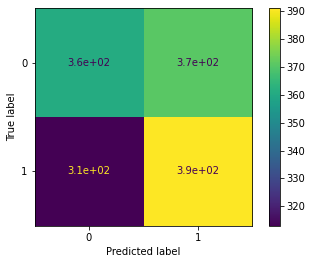

In [ ]:
# show_val_res_label(y_test_label, y_pred)
show_val_res_label(y_test_scaled_label, y_pred)